In [75]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [76]:
from fastai.vision import *
from fastai import *
import pandas as pd
from pathlib import Path
import numpy as np

In [77]:
from google.colab import drive                                    # I place the dataset to google drive and imported from there

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [78]:
path = Path('/content/drive/MyDrive/MRI')

In [79]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid",
        ds_tfms=get_transforms(), size=(256,256), bs=16, num_workers=4).normalize()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [80]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['0', '1', '2'], 3, 2430, 642)

In [81]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 2430
Number of examples in validation: 642


In [82]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16]))

In [83]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [84]:
def double_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
    )



In [85]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [86]:
model = nn.Sequential(
    conv_block(3, 8),
    conv_block(8, 16),
    maxpooling(),
    double_conv(16, 32),
    maxpooling(),
    double_conv(16, 32),
    conv_block(16, 32),
    maxpooling(),
    double_conv(32, 64),
    conv_block(32, 64),
    maxpooling(),
    conv_block(64, 128),
    conv_block(128, 256),
    double_conv(256, 512),
    maxpooling(),
    conv_block(256, 3),
    Flatten(),
    nn.Linear(243, 3)

)

In [87]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [88]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
Conv2d               [16, 256, 256]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 256, 256]       32         True      
______________________________________________________________________
LeakyReLU            [16, 256, 256]       0          False     
______________________________________________________________________
MaxPool2d            [16, 128, 128]       0          False     
___________________________________________________

In [89]:
CUDA_LAUNCH_BLOCKING=1

In [90]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.704355,0.566796,0.803738,00:42
1,0.573834,0.564253,0.755452,00:42
2,0.457607,0.495806,0.766355,00:42
3,0.446001,0.341645,0.869159,00:42
4,0.435439,0.429562,0.803738,00:41
5,0.405713,0.286884,0.884735,00:42
6,0.398458,0.408289,0.831776,00:41
7,0.419072,0.543543,0.788162,00:41
8,0.397722,0.582198,0.733645,00:42
9,0.384041,0.437101,0.811526,00:41


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


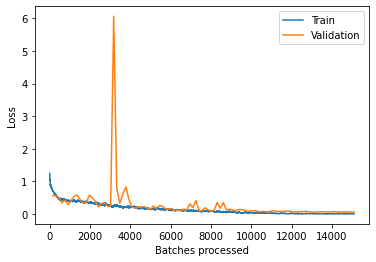

In [91]:
learn.recorder.plot_losses()

In [92]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [93]:
accuracy(probs,targets)

tensor(0.9860)

In [94]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


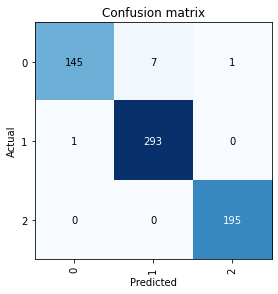

In [95]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

In [96]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['0', '1', '2'], 3, 2430, 642)

In [97]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Meningiomas', 'Gliomas', 'Pituitary tumors']
print(classification_report(y_true1, y_pred1, target_names=target_names))

642 633 0.985981308411215
[[145   7   1]
 [  1 293   0]
 [  0   0 195]]
                  precision    recall  f1-score   support

     Meningiomas       0.99      0.95      0.97       153
         Gliomas       0.98      1.00      0.99       294
Pituitary tumors       0.99      1.00      1.00       195

        accuracy                           0.99       642
       macro avg       0.99      0.98      0.98       642
    weighted avg       0.99      0.99      0.99       642

